<h2> NLP Classification - SMS Spam detection system </h2>

In this notebook we'll study how to make a SMS Spam detection system based on NLP classification using different methods such as Naive Baye, LSTM and transformers (Bert in particular).

<h3> Introduction - Quick Data exploration </h3>

In [1]:
import os
import re
import nltk
import unidecode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split

data = pd.read_csv(("spam.csv"), encoding='latin1')
data = data[['v1', 'v2']]
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
print('Number of NaN values:\n' + str(data.isnull().sum()))

Number of NaN values:
v1    0
v2    0
dtype: int64


<h3> Part I - Naive Baye Classification: </h3>

train len: 4736
test len: 836
Accuracy: 0.9856459330143541


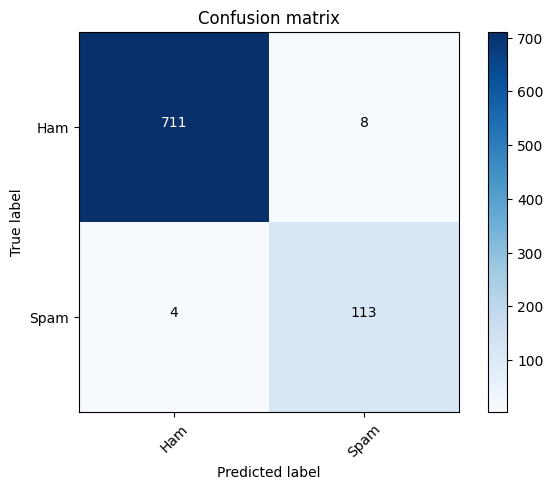

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def NB_text_processing(text):
    ''' Return cleaned text for Machine Learning '''
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    NEW_LINE = re.compile('\n')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(nltk.corpus.stopwords.words('english'))
    STEMMER = SnowballStemmer('english')

    text = text.lower()
    text = unidecode.unidecode(text)
    text = NEW_LINE.sub(' ',text)
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub('',text)
    text = ' '.join([STEMMER.stem(word) for word in text.split() if word not in STOPWORDS])
    return text

def NB_preprocessing(data):
    ''' Return train, validation and test set '''
    X = data['v2'].tolist()
    X = [NB_text_processing(txt) for txt in X]
    cv = CountVectorizer(max_features = 5000)

    X = cv.fit_transform(X).toarray()
    Y = data['v1'].tolist()
    
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.15,train_size=0.85)
    print('train len:', len(x_train))
    print('test len:', len(x_test))

    return x_train, x_test, y_train, y_test

def NB_Model(data):
    ''' Create a model based on Naive Bayes '''
    x_train, x_test, y_train, y_test = NB_preprocessing(data)
    classifier = MultinomialNB()
    classifier.fit(x_train, y_train)

    y_pred = classifier.predict(x_test)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Ham', 'Spam'])

NB_Model(data)

Well... This is too good to be true... It is almost perfect with only Naive Baye with 98.56% accuracy.

<h3> Part II - LSTM Classification: </h3>

In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences

X = data['v2'].apply(lambda x: NB_text_processing(x))
Y = data['v1'].tolist()
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
Y.reshape(-1, 1)
print(X)

c=[]
for i in range(len(X)):
    m=len(X[i].split())
    c.append(m)
print('Maximum length of a sentence is : ',max(c))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

X = pad_sequences(tokenizer.texts_to_sequences(X), maxlen = max(c))
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.15,train_size=0.85)

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri 2 wkli comp win fa cup final tkts 2...
3                     u dun say earli hor u c alreadi say
4               nah dont think goe usf live around though
                              ...                        
5567    2nd time tri 2 contact u u a750 pound prize 2 ...
5568                             i_ b go esplanad fr home
5569                              piti mood soani suggest
5570    guy bitch act like id interest buy someth els ...
5571                                       rofl true name
Name: v2, Length: 5572, dtype: object
Maximum length of a sentence is :  80
Vocabulary Size : 7915


In [12]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

''' You have to download this file: http://nlp.stanford.edu/data/glove.6B.zip
    his weight is 1GO !'''

EMBEDDING_DIM = 300
BATCH_SIZE = 512

embeddings_index = {}

f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(vocab_size
    , EMBEDDING_DIM
    , weights=[embedding_matrix]
    , input_length=max(c)
    , trainable=False)

Found 400000 word vectors.


In [13]:
def MakeModel():
    sequence_input = Input(shape=(max(c),), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(sequence_input, outputs)
    print(model.summary())
    return model

model = MakeModel()
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80)]              0         
                                                                 
 embedding (Embedding)       (None, 80, 300)           2374500   
                                                                 
 spatial_dropout1d (SpatialD  (None, 80, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 76, 64)            96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048 

In [14]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=4, validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/4
10/10 [==============================] - 9s 631ms/step - loss: 0.4565 - accuracy: 0.8638 - val_loss: 0.2831 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 2/4
10/10 [==============================] - 6s 588ms/step - loss: 0.2282 - accuracy: 0.8649 - val_loss: 0.1646 - val_accuracy: 0.9378 - lr: 0.0010
Epoch 3/4
10/10 [==============================] - 6s 634ms/step - loss: 0.1459 - accuracy: 0.9584 - val_loss: 0.1159 - val_accuracy: 0.9689 - lr: 0.0010
Epoch 4/4
10/10 [==============================] - 6s 615ms/step - loss: 0.0952 - accuracy: 0.9717 - val_loss: 0.0757 - val_accuracy: 0.9773 - lr: 0.0010


27/27 [==============================] - 1s 10ms/step
Accuracy: 0.9772727272727273


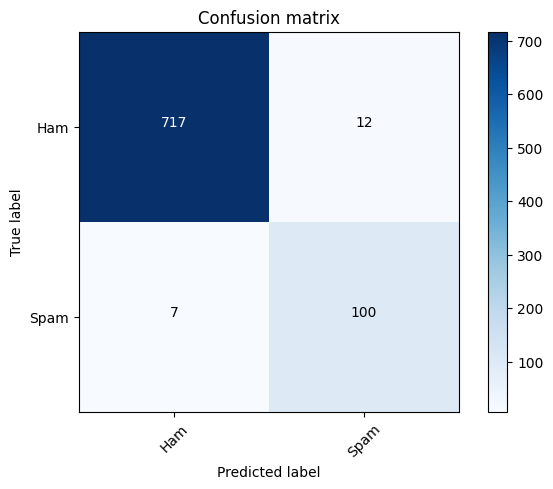

In [15]:
threshold = 0.5

y_tmp = model.predict(x_test)
y_pred = []
for i in range(len(y_tmp)):
    if(y_tmp[i] > threshold): y_pred.append(1)
    else: y_pred.append(0)
print('Accuracy:', accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Ham', 'Spam'])

This is almost the same accuracy as Naive Baye with 97.72%

<h3> Part III - Bert Classification: </h3>

In [16]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

def Bert_preprocess_text(text, device, tokenizer):
    ''' Split text in chunks of 'delta' words strictly then encode it'''
    parts = []
    text_len = len(text.split(' '))
    delta = 200
    max_parts = 5
    nb_cuts = int(text_len / delta)
    nb_cuts = min(nb_cuts, max_parts)
    
    for i in range(nb_cuts + 1):
        text_part = ' '.join(text.split(' ')[i * delta: (i + 1) * delta])
        parts.append(tokenizer.encode(text_part, return_tensors="pt", max_length=500).to(device))

    return parts

def Bert_train_epoch(model, x_train, y_train, loss_fn, optimizer, device, tokenizer):
    ''' Train Bert model for one epoch '''
    print_every = 300; total_loss = 0
    all_losses = []
    model.train()
    correct_predictions = 0
    for idx in range(len(x_train)):
        text_parts = Bert_preprocess_text(x_train[idx], device, tokenizer)
        label = torch.tensor([y_train[idx]]).long().to(device)
        overall_output = torch.zeros(2).float().to(device)
        for part in text_parts:
            if len(part) > 0:
                try:
                    input = part.reshape(-1)[:512].reshape(1, -1)
                    overall_output += (model(input, labels=label)[1].float().to(device))[0]
                except Exception as e:
                    print(str(e))
        correct_predictions += (np.argmax(overall_output.cpu().detach().numpy()) == label).item()
        if label == 0: label = torch.tensor([1.0, 0.0]).float().to(device)
        elif label == 1: label = torch.tensor([0.0, 1.0]).float().to(device)
        loss = loss_fn(overall_output, label)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if idx % print_every == 0 and idx > 0:
            average_loss = total_loss / print_every
            print("{}/{}. Average loss: {} | Accuracy: {}%".format(idx, len(x_train), average_loss, (correct_predictions/idx)*100))
            all_losses.append(average_loss)
            total_loss = 0
            
def Bert_eval_model(model, x_val, y_val, loss_fn, device, tokenizer):
    ''' Evaluate Bert model on validation data '''
    total_loss = 0; all_losses = []
    model.eval()
    correct_predictions = 0
    with torch.no_grad():
        for idx in range(len(x_val)):
            text_parts = Bert_preprocess_text(x_val[idx], device, tokenizer)
            label = torch.tensor([y_val[idx]]).long().to(device)
            overall_output = torch.zeros(2).float().to(device)
            for part in text_parts:
                if len(part) > 0:
                    try:
                        input = part.reshape(-1)[:512].reshape(1, -1)
                        overall_output += (model(input, labels=label)[1].float().to(device))[0]
                    except Exception as e:
                        print(str(e))
            correct_predictions += (np.argmax(overall_output.cpu().detach().numpy()) == label).item()
            if label == 0: label = torch.tensor([1.0, 0.0]).float().to(device)
            elif label == 1: label = torch.tensor([0.0, 1.0]).float().to(device)
            loss = loss_fn(overall_output, label)
            total_loss += loss.item()
        average_loss = total_loss / len(x_val)
        print("Average val loss: {} | Val accuracy: {}%".format(average_loss, (correct_predictions/len(x_val))*100))
        all_losses.append(average_loss)
        total_loss = 0
    

def Bert_train_model(X, Y):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    x, x_test, y, y_test = train_test_split(X,Y,test_size=0.05,train_size=0.95)
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.15,train_size=0.85)
    
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
    model.config.num_labels = 1
    for param in model.parameters():
        param.requires_grad = False #Freeze Bert !
    model.classifier = nn.Sequential(
        nn.Linear(model.config.hidden_size, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 2),
        nn.Softmax(dim=1)
    )
    model = model.to(device)
    
    criterion = nn.BCELoss().to(device)
    optimizer = optim.AdamW(model.classifier.parameters(), lr=3e-5)
    
    EPOCHS = 3
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)
        Bert_train_epoch(model, x_train, y_train, criterion, optimizer, device, tokenizer)
        Bert_eval_model(model, x_val, y_val, criterion, device, tokenizer)
        
X = data['v2'].tolist()
Y = (data['v1'] == 'ham').astype(int).tolist()
Bert_train_model(X, Y)

C:\Users\Seren\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequence


Epoch 1/3
----------
300/4499. Average loss: 0.41569043879707657 | Accuracy: 87.66666666666667%
600/4499. Average loss: 0.3709786109998822 | Accuracy: 87.33333333333333%
900/4499. Average loss: 0.4147448771446943 | Accuracy: 85.77777777777777%
1200/4499. Average loss: 0.3673718260601163 | Accuracy: 85.41666666666666%
1500/4499. Average loss: 0.29395912083486714 | Accuracy: 85.8%
1800/4499. Average loss: 0.2775131854104499 | Accuracy: 86.11111111111111%
2100/4499. Average loss: 0.252270707928886 | Accuracy: 86.61904761904762%
2400/4499. Average loss: 0.2923661107942462 | Accuracy: 86.5%
2700/4499. Average loss: 0.2772888728727897 | Accuracy: 86.55555555555556%
3000/4499. Average loss: 0.21875796818329643 | Accuracy: 87.03333333333333%
3300/4499. Average loss: 0.26912423270754515 | Accuracy: 87.15151515151514%
3600/4499. Average loss: 0.25269784283669045 | Accuracy: 87.25%
3900/4499. Average loss: 0.19488122708164154 | Accuracy: 87.71794871794872%
4200/4499. Average loss: 0.203844063046